In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from scipy.stats import norm, uniform, chi2

import arviz as az

In [2]:
dat = pd.read_csv('Howell1.csv', sep=';')

# We are interested in adult's height
dat_adults = dat[dat['age'] >= 18]

## Construction and fit of a Bayesian probability model

### How to determine a reasonable prior distribution?

The prior predictive is an essential part of our modeling. By simulating from this distribution, we can see what our choices imply about observable height. This helps us diagnose bad choices. Lots of conventional choices are indeed bad ones, and we'll be able to see this through prior predictive simulations.

(array([4.400e+01, 2.340e+02, 1.375e+03, 4.810e+03, 2.839e+03, 5.790e+02,
        1.080e+02, 9.000e+00, 1.000e+00, 1.000e+00]),
 array([ 77.72946087, 102.35512848, 126.98079609, 151.60646369,
        176.2321313 , 200.85779891, 225.48346652, 250.10913412,
        274.73480173, 299.36046934, 323.98613695]),
 <BarContainer object of 10 artists>)

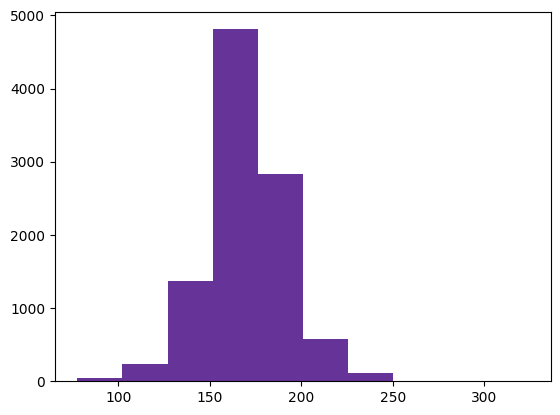

In [3]:
n_prior          = 10**4

sample_mu        = norm.rvs(size=n_prior, loc=170, scale=10)
sample_sigma     = uniform.rvs(size=n_prior, loc=0, scale=33)
prior_predictive = norm.rvs(size=n_prior, loc=sample_mu, scale=sample_sigma)

plt.hist(prior_predictive, color='rebeccapurple')

(array([   6.,   64.,  435., 1629., 2956., 2911., 1534.,  402.,   58.,
           5.]),
 array([-250.0176114 , -165.79171968,  -81.56582796,    2.66006377,
          86.88595549,  171.11184721,  255.33773893,  339.56363065,
         423.78952238,  508.0154141 ,  592.24130582]),
 <BarContainer object of 10 artists>)

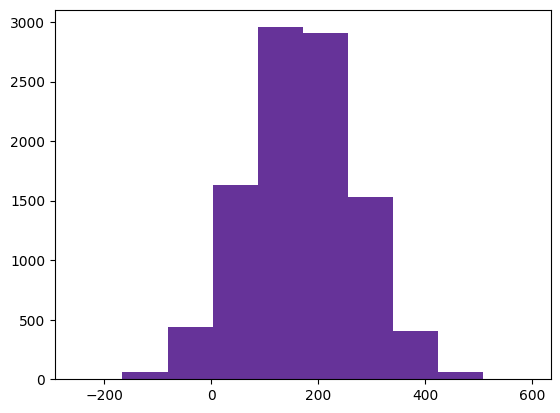

In [4]:
sample_mu        = norm.rvs(size=n_prior, loc=170, scale=100)
sample_sigma     = uniform.rvs(size=n_prior, loc=0, scale=33)
prior_predictive = norm.rvs(size=n_prior, loc=sample_mu, scale=sample_sigma)

plt.hist(prior_predictive, color='rebeccapurple')

### Return to the reasonable prior

(array([3.000e+00, 2.800e+01, 2.110e+02, 1.036e+03, 4.063e+03, 3.559e+03,
        8.840e+02, 1.910e+02, 2.100e+01, 4.000e+00]),
 array([ 57.56605309,  80.39807732, 103.23010155, 126.06212578,
        148.89415002, 171.72617425, 194.55819848, 217.39022271,
        240.22224694, 263.05427117, 285.8862954 ]),
 <BarContainer object of 10 artists>)

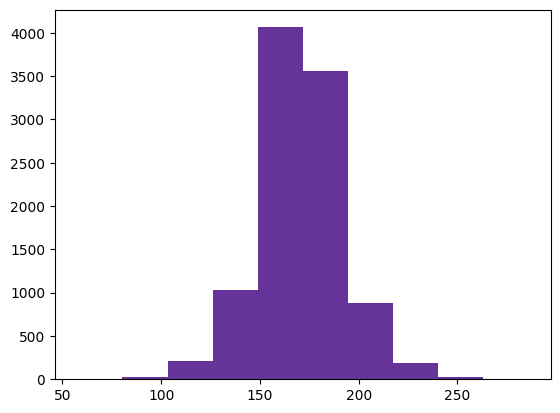

In [5]:
sample_mu        = norm.rvs(size=n_prior, loc=170, scale=10)
sample_sigma     = uniform.rvs(size=n_prior, loc=0, scale=33)
prior_predictive = norm.rvs(size=n_prior, loc=sample_mu, scale=sample_sigma)

plt.hist(prior_predictive, color='rebeccapurple')

### Calculate likelihood x prior

In [6]:
mu_list             = np.linspace(153.5, 155.5, 100)
sigma_list          = np.linspace(7, 8.5, 100)
mu_grid, sigma_grid = np.meshgrid(mu_list, sigma_list)

In [7]:
like = []

for i in range(len(mu_grid.ravel())):
    like.append(norm.logpdf(dat_adults['height'], mu_grid.ravel()[i], sigma_grid.ravel()[i]).sum())
    
like = np.array(like).reshape(mu_grid.shape)

### Estimate the posterior

In [8]:
post_prod = like + norm.logpdf(mu_grid, 170, 10) + uniform.logpdf(sigma_grid, loc=0, scale=33)

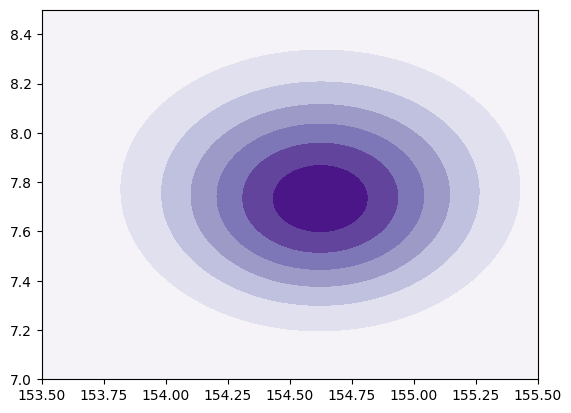

In [9]:
plt.contourf(mu_grid, sigma_grid, np.exp(post_prod - post_prod.max()), cmap='Purples')

### Use the normal approximation to get a region of posterior probability of $(1-\alpha)\times 100\%$.

/tmp/ipykernel_4654/2014267051.py:3: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(


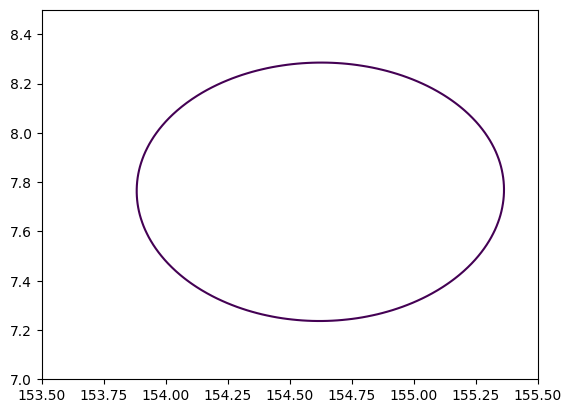

In [10]:
alpha = 0.2

plt.contour(
    mu_grid
    , sigma_grid
    , np.exp(post_prod - post_prod.max())
    #, cmap='Purples'
    , levels=[
        np.exp(-0.5 * chi2.ppf(1-alpha, 2))
        ]
    , color='rebeccapurple'
    )

### Generate a sample from the posterior

In [11]:
n_posterior = 10**4

candidates = pd.DataFrame(np.c_[mu_grid.ravel(), sigma_grid.ravel()], columns=['mu', 'sigma'])
sample_ind = random.choices(range(candidates.shape[0]), weights=np.exp(post_prod - post_prod.max()).ravel(), k=n_posterior)
posterior_sample = candidates.iloc[sample_ind]
posterior_sample = posterior_sample.reset_index(drop=True)

<AxesSubplot:xlabel='mu', ylabel='sigma'>

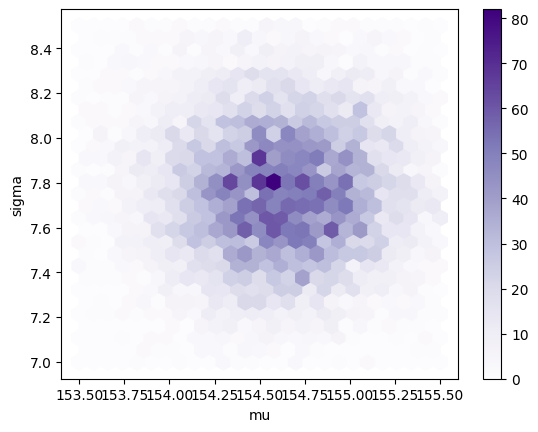

In [12]:
posterior_sample.plot.hexbin(x='mu', y='sigma', cmap='Purples', gridsize=25)

In [13]:
posterior_sample.describe()

,mu,sigma
count,10000.000000,10000.000000
mean,154.612261,7.763220
std,0.387796,0.283843
min,153.500000,7.000000
25%,154.348485,7.560606
50%,154.611111,7.757576
75%,154.893939,7.954545
max,155.500000,8.500000


In [14]:
az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)

/tmp/ipykernel_4654/1197683196.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)


array([[154.34848485, 154.87373737],
       [  7.56060606,   7.93939394]])

## Model Checking

Once we have accomplished the first two steps of a Bayesian analysis—constructing a probability model and computing the posterior distribution of all estimands—we should not ignore the relatively easy step of assessing the fit of the model to the data and to our
substantive knowledge. It is difficult to include in a probability distribution all of one’s knowledge about a problem, and so it is wise to investigate what aspects of reality are *not* captured by the model.

A good Bayesian analysis, therefore, should include at least some check of the adequacy of the fit of the model to the data and the **plausibility of the model for the purposes for which the model will be used**. We do not like to ask, ‘Is our model true or false?’, The more relevant question is, **‘Do the model’s deficiencies have a noticeable effect on the substantive inferences?’**

If the model fits, then replicated data generated under the model should look similar to observed data. To put it another way, the observed data should look plausible under the posterior predictive distribution. Our basic technique for checking the fit of a model to data is to draw simulated values from the joint posterior predictive distribution of replicated data and compare these samples to the observed data.

In [15]:
posterior_predictive_samples = []

for i in range(n_posterior):
     posterior_predictive_samples.append(
        norm.rvs(
            size=len(dat_adults)
            , loc=posterior_sample.iloc[i]['mu']
            , scale=posterior_sample.iloc[i]['sigma'])
        )

posterior_predictive_samples = np.array(posterior_predictive_samples)

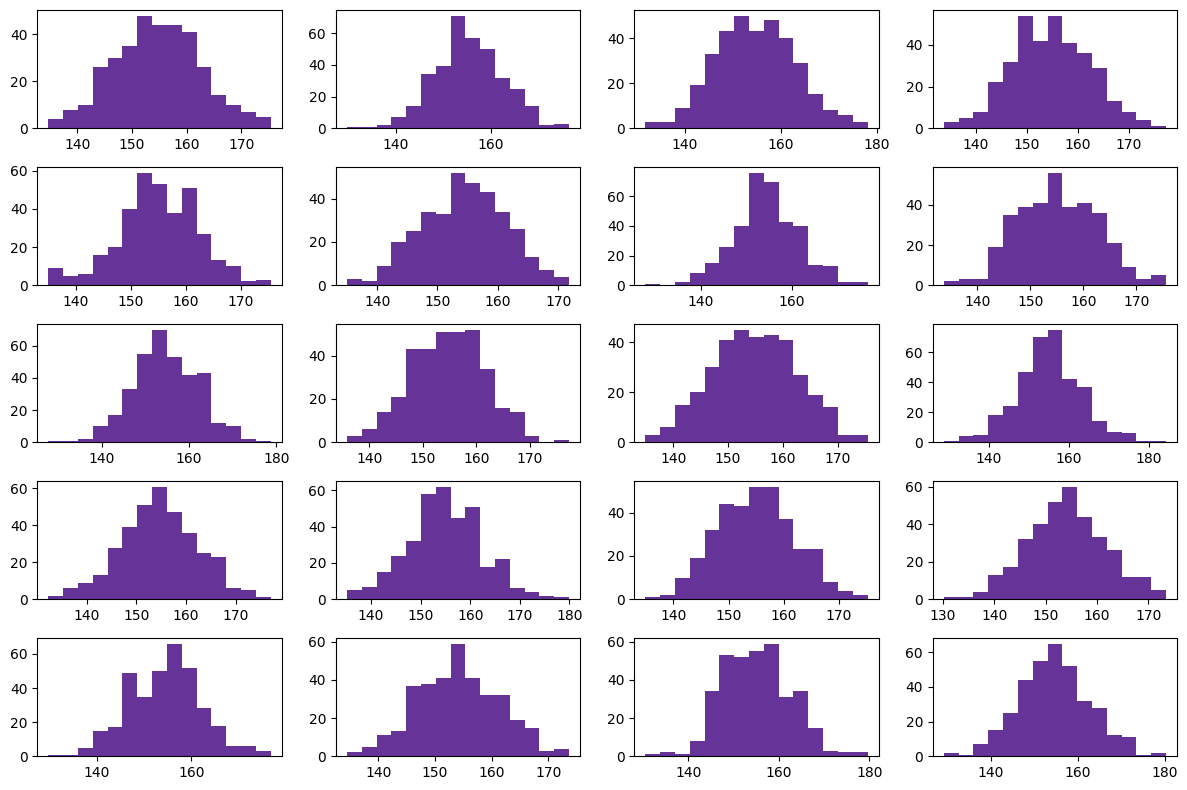

In [16]:
fig, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5)

ind = 0
for j in range(5):
    for k in range(4):
        axs[j, k].hist(posterior_predictive_samples[ind], bins=15, color='rebeccapurple')
        ind = ind + 1
        
fig.tight_layout()

Text(0.5, 1.0, 'Distribution of the measurements')

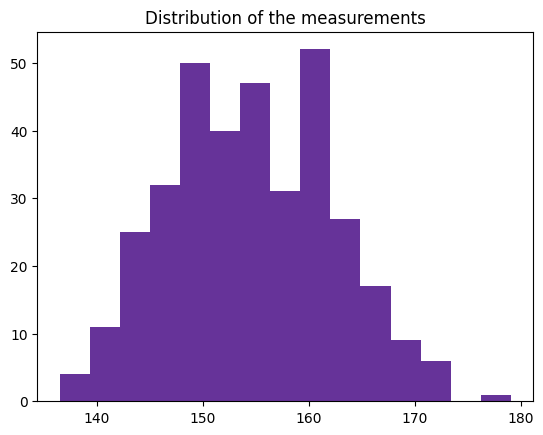

In [17]:
plt.hist(dat_adults['height'], bins=15, color='rebeccapurple')
plt.title('Distribution of the measurements')

### Test quantities and p-values

0.5121

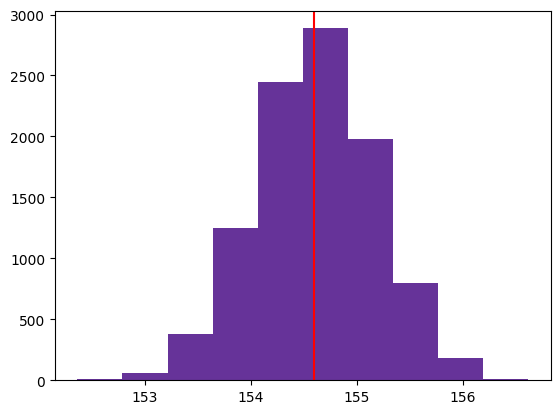

In [18]:
plt.hist(posterior_predictive_samples.mean(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].mean(), color='r')

# p-value
(posterior_predictive_samples.mean(axis=1) > dat_adults['height'].mean()).mean()

0.4993

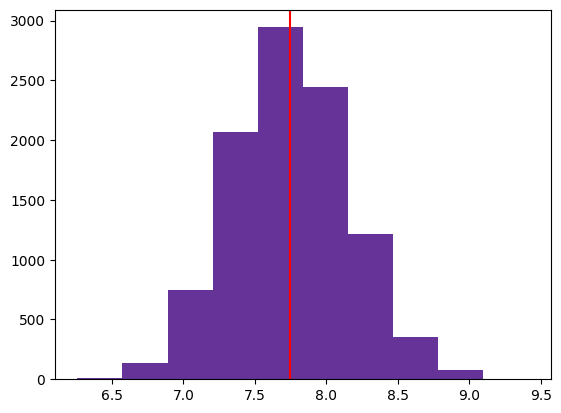

In [19]:
plt.hist(posterior_predictive_samples.std(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].std(), color='r')

# p-value
(posterior_predictive_samples.std(axis=1) > dat_adults['height'].std()).mean()

0.042

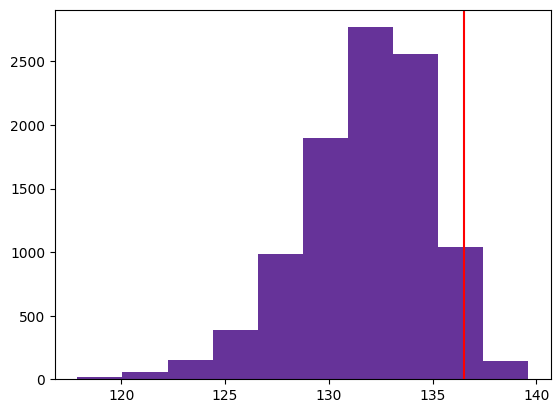

In [20]:
plt.hist(posterior_predictive_samples.min(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].min(), color='r')

# p-value
(posterior_predictive_samples.min(axis=1) > dat_adults['height'].min()).mean()

Does this mean that the model is bad? That depends. The model will always be wrong in some sense, be *mis-specified*. But **whether or not the mis-specification should lead us to try other models will depend upon our specific interests.**

## How do the results change with less data?

In [21]:
dat_adults_2 = dat_adults.sample(20, random_state=111)

In [22]:
mu_list             = np.linspace(152, 159, 100)
sigma_list          = np.linspace(4.5, 9.5, 100)
mu_grid, sigma_grid = np.meshgrid(mu_list, sigma_list)

In [23]:
like = []

for i in range(len(mu_grid.ravel())):
    like.append(norm.logpdf(dat_adults_2['height'], mu_grid.ravel()[i], sigma_grid.ravel()[i]).sum())
    
like = np.array(like).reshape(mu_grid.shape)

In [24]:
post_prod = like + norm.logpdf(mu_grid, 170, 10) + uniform.logpdf(sigma_grid, loc=0, scale=33)

### Estimate the posterior

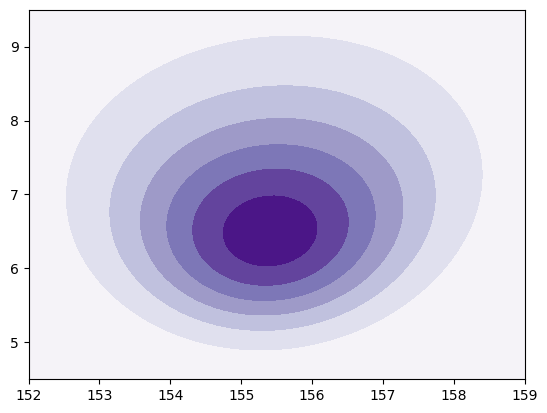

In [25]:
plt.contourf(mu_grid, sigma_grid, np.exp(post_prod - post_prod.max()), cmap='Purples')

### Generate a sample from the posterior

In [26]:
candidates = pd.DataFrame(np.c_[mu_grid.ravel(), sigma_grid.ravel()], columns=['mu', 'sigma'])
sample_ind = random.choices(range(candidates.shape[0]), weights=np.exp(post_prod - post_prod.max()).ravel(), k=10**4)
posterior_sample = candidates.iloc[sample_ind]
posterior_sample = posterior_sample.reset_index(drop=True)

<AxesSubplot:xlabel='mu', ylabel='sigma'>

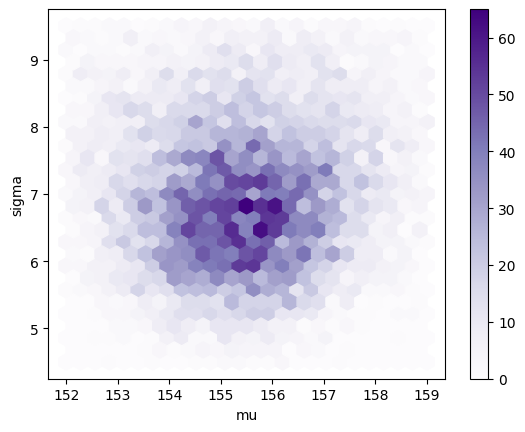

In [27]:
posterior_sample.plot.hexbin(x='mu', y='sigma', cmap='Purples', gridsize=25)

In [28]:
posterior_sample.describe()

,mu,sigma
count,10000.000000,10000.000000
mean,155.432659,6.960838
std,1.421275,1.028078
min,152.000000,4.500000
25%,154.404040,6.166667
50%,155.393939,6.873737
75%,156.454545,7.681818
max,159.000000,9.500000


In [29]:
az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)

/tmp/ipykernel_4654/1197683196.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)


array([[154.05050505, 156.03030303],
       [  5.81313131,   7.22727273]])

### Model checking

In [30]:
posterior_predictive_samples = []

for i in range(n_posterior):
     posterior_predictive_samples.append(
        norm.rvs(
            size=len(dat_adults_2)
            , loc=posterior_sample.iloc[i]['mu']
            , scale=posterior_sample.iloc[i]['sigma'])
        )

posterior_predictive_samples = np.array(posterior_predictive_samples)

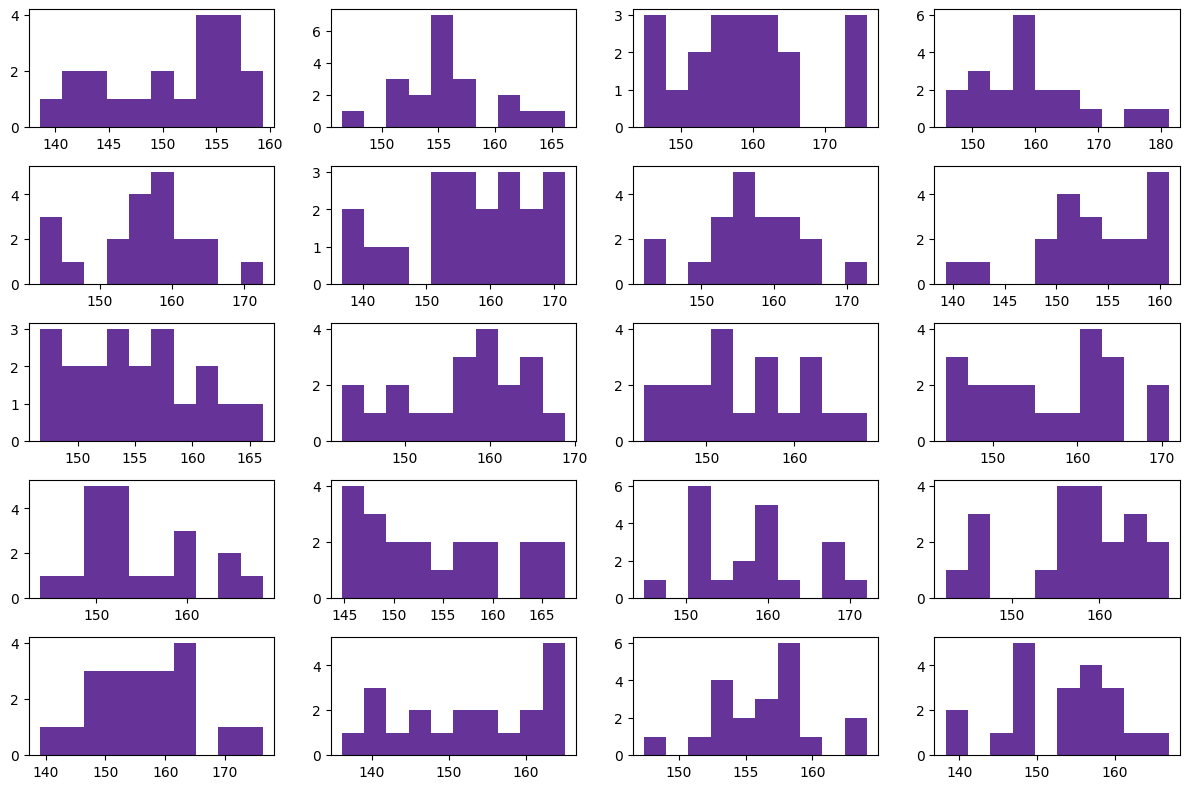

In [31]:
fig, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5)

ind = 0
for j in range(5):
    for k in range(4):
        axs[j, k].hist(posterior_predictive_samples[ind], color='rebeccapurple')
        ind = ind + 1
        
fig.tight_layout()

Text(0.5, 1.0, 'Distribution of the measurements')

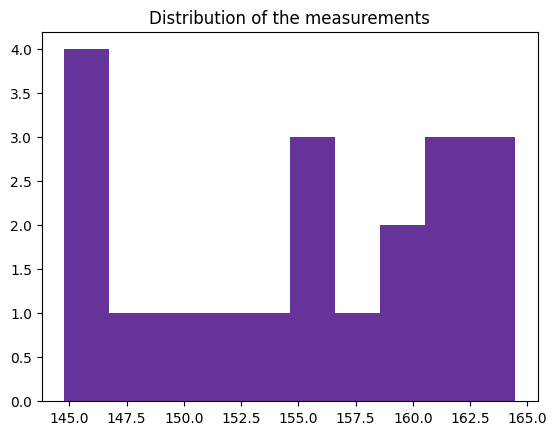

In [32]:
plt.hist(dat_adults_2['height'], color='rebeccapurple')
plt.title('Distribution of the measurements')

### Test quantities and p-values

0.5614

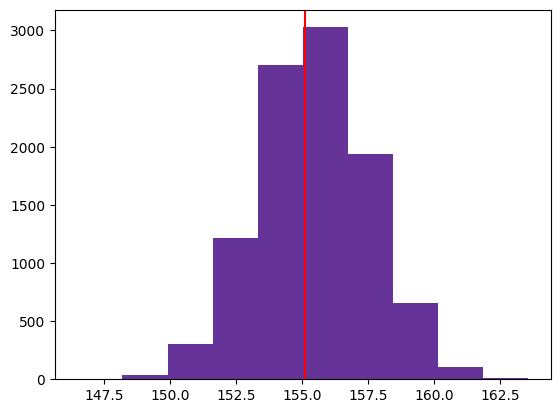

In [33]:
plt.hist(posterior_predictive_samples.mean(axis=1), color='rebeccapurple')
plt.axvline(dat_adults_2['height'].mean(), color='r')

# p-value
(posterior_predictive_samples.mean(axis=1) > dat_adults_2['height'].mean()).mean()

0.4891

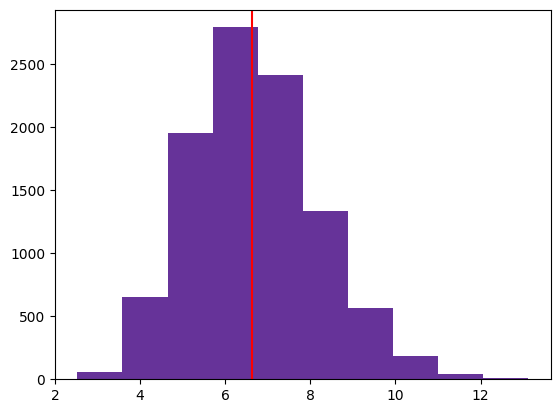

In [34]:
plt.hist(posterior_predictive_samples.std(axis=1), color='rebeccapurple')
plt.axvline(dat_adults_2['height'].std(), color='r')

# p-value
(posterior_predictive_samples.std(axis=1) > dat_adults_2['height'].std()).mean()

0.3185

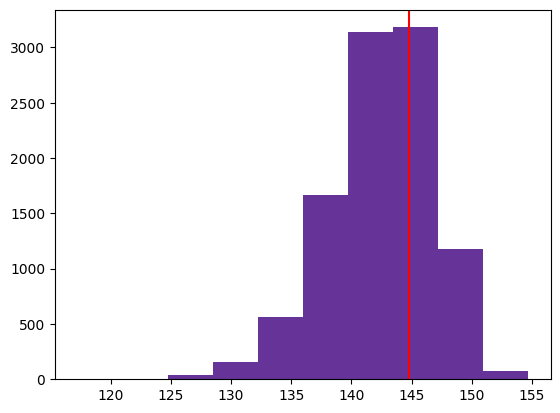

In [35]:
plt.hist(posterior_predictive_samples.min(axis=1), color='rebeccapurple')
plt.axvline(dat_adults_2['height'].min(), color='r')

# p-value
(posterior_predictive_samples.min(axis=1) > dat_adults_2['height'].min()).mean()

## How does the result change with other prior for $\mu$?

In [36]:
mu_list             = np.linspace(169.5, 170.5, 100)
sigma_list          = np.linspace(15, 20, 100)
mu_grid, sigma_grid = np.meshgrid(mu_list, sigma_list)

In [37]:
like = []

for i in range(len(mu_grid.ravel())):
    like.append(norm.logpdf(dat_adults['height'], mu_grid.ravel()[i], sigma_grid.ravel()[i]).sum())
    
like = np.array(like).reshape(mu_grid.shape)

In [38]:
post_prod = like + norm.logpdf(mu_grid, 170, 0.1) + uniform.logpdf(sigma_grid, loc=0, scale=33)

### Estimate the posterior

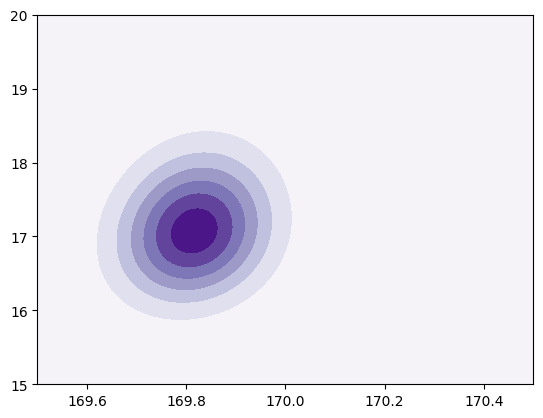

In [39]:
plt.contourf(mu_grid, sigma_grid, np.exp(post_prod - post_prod.max()), cmap='Purples')

### Generate a sample from the posterior

In [40]:
candidates = pd.DataFrame(np.c_[mu_grid.ravel(), sigma_grid.ravel()], columns=['mu', 'sigma'])
sample_ind = random.choices(range(candidates.shape[0]), weights=np.exp(post_prod - post_prod.max()).ravel(), k=10**4)
posterior_sample = candidates.iloc[sample_ind]
posterior_sample = posterior_sample.reset_index(drop=True)

<AxesSubplot:xlabel='mu', ylabel='sigma'>

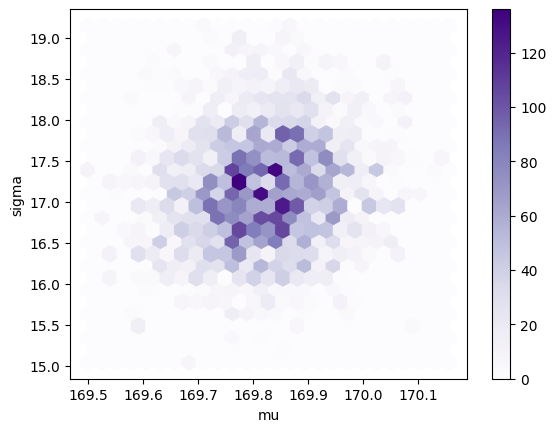

In [41]:
posterior_sample.iloc[sample_ind].plot.hexbin(x='mu', y='sigma', cmap='Purples', gridsize=25)

In [42]:
posterior_sample.describe()

,mu,sigma
count,10000.000000,10000.000000
mean,169.817619,17.126364
std,0.099157,0.657276
min,169.500000,15.050505
25%,169.752525,16.666667
50%,169.813131,17.121212
75%,169.883838,17.575758
max,170.176768,19.848485


In [43]:
az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)

/tmp/ipykernel_4654/1197683196.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.hdi(posterior_sample.to_numpy(), hdi_prob=0.5)


array([[169.73232323, 169.86363636],
       [ 16.51515152,  17.37373737]])

### Model checking

In [44]:
posterior_predictive_samples = []

for i in range(n_posterior):
     posterior_predictive_samples.append(
        norm.rvs(
            size=len(dat_adults)
            , loc=posterior_sample.iloc[i]['mu']
            , scale=posterior_sample.iloc[i]['sigma'])
        )

posterior_predictive_samples = np.array(posterior_predictive_samples)

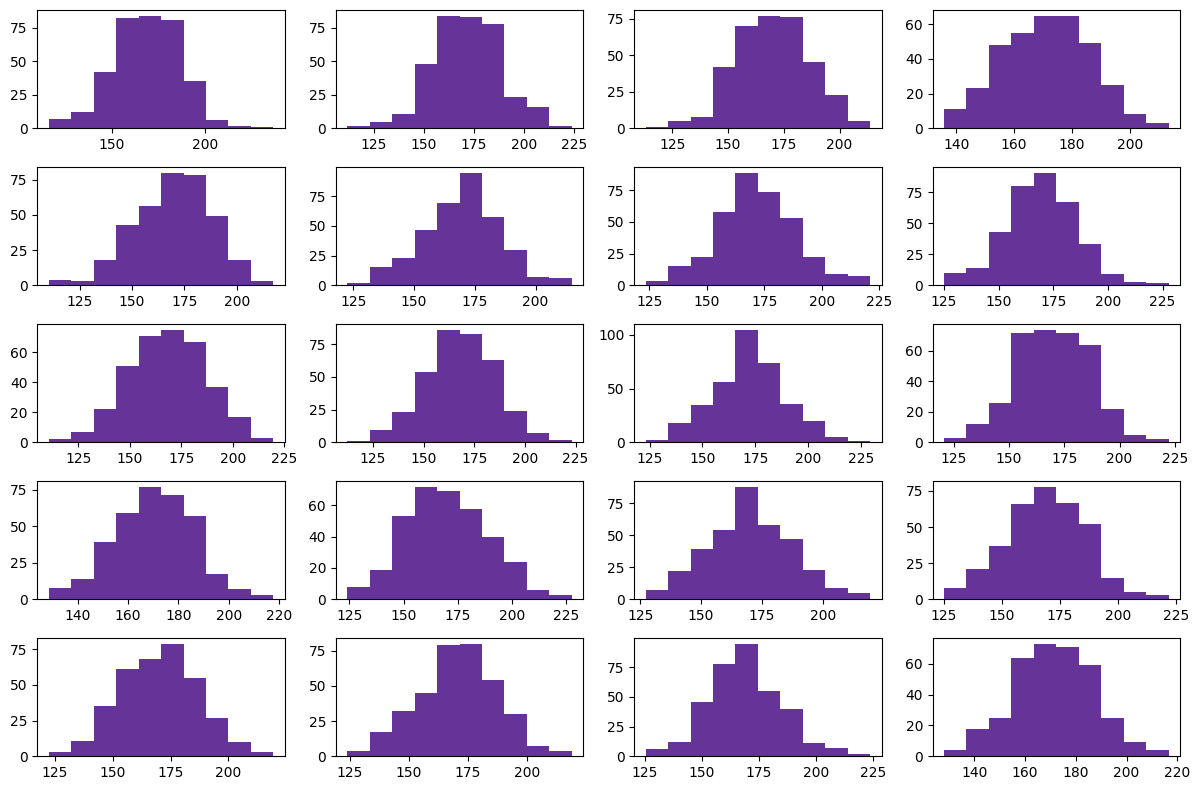

In [45]:
fig, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5)

ind = 0
for j in range(5):
    for k in range(4):
        axs[j, k].hist(posterior_predictive_samples[ind], color='rebeccapurple')
        ind = ind + 1
        
fig.tight_layout()

Text(0.5, 1.0, 'Distribution of the measurements')

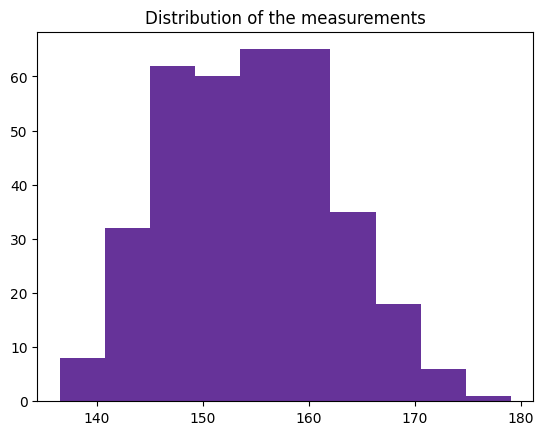

In [46]:
plt.hist(dat_adults['height'], color='rebeccapurple')
plt.title('Distribution of the measurements')

### Test quantities and p-values

1.0

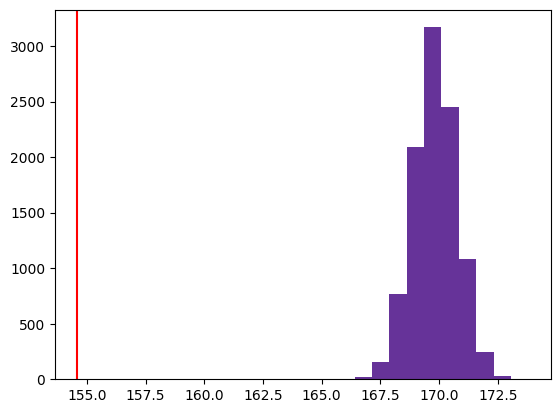

In [47]:
plt.hist(posterior_predictive_samples.mean(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].mean(), color='r')

# p-value
(posterior_predictive_samples.mean(axis=1) > dat_adults['height'].mean()).mean()

1.0

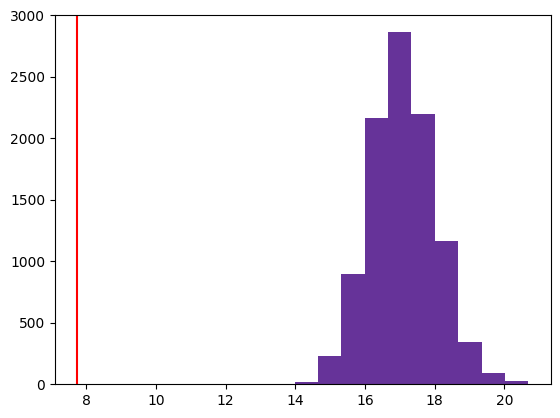

In [48]:
plt.hist(posterior_predictive_samples.std(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].std(), color='r')

# p-value
(posterior_predictive_samples.std(axis=1) > dat_adults['height'].std()).mean()

0.0

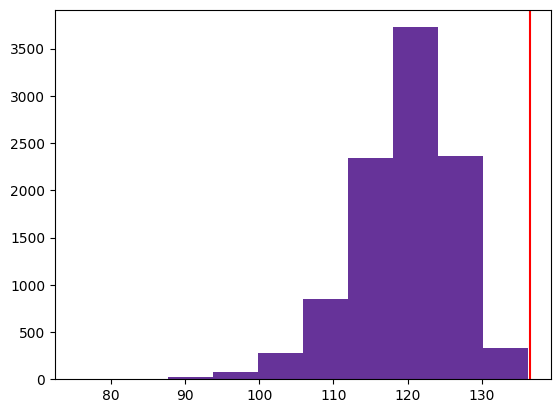

In [49]:
plt.hist(posterior_predictive_samples.min(axis=1), color='rebeccapurple')
plt.axvline(dat_adults['height'].min(), color='r')

# p-value
(posterior_predictive_samples.min(axis=1) > dat_adults['height'].min()).mean()